## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
print('imported')

%matplotlib inline

imported


In [2]:
def loadimage(name,typ='rgb'):
    img=cv2.imread(name)
    if typ=='bgr':
        return img
    elif typ=='rgb':
        img=img[...,::-1] #bgr2rgb
        return img
    elif typ=='gray':
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        return gray
    else:
        print('error')

def plot2imgs(im1,im2,txt1,txt2):        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title(txt1, fontsize=50)
    ax2.imshow(im2)
    ax2.set_title(txt2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
def plot3imgs(im1,im2,im3,txt1,txt2,txt3):        
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 9))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title(txt1, fontsize=50)
    ax2.imshow(im2)
    ax2.set_title(txt2, fontsize=50)
    ax3.imshow(im3)
    ax3.set_title(txt3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


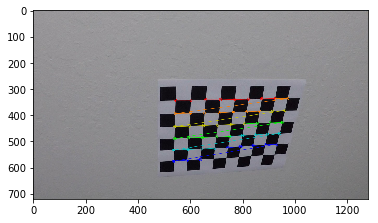

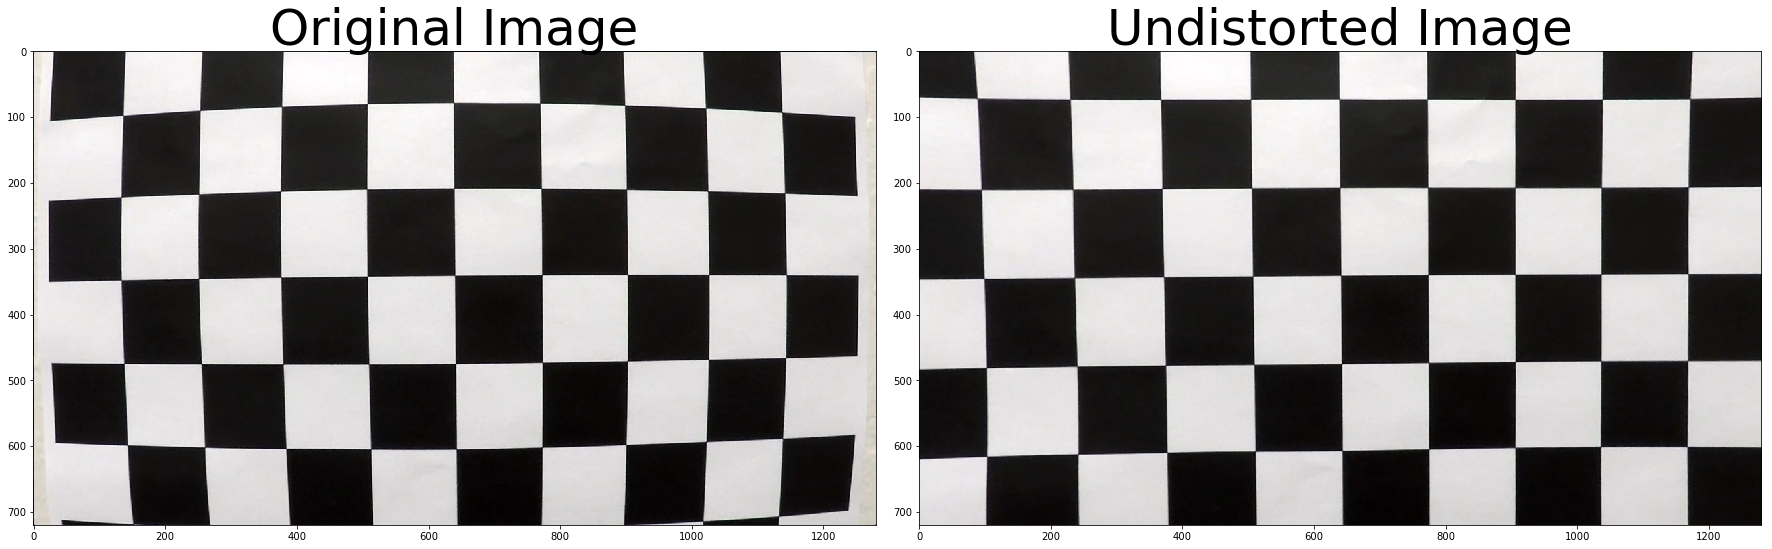

In [19]:
n_xcorner=9
n_ycorner=6
objpoint = np.zeros((n_xcorner*n_ycorner,3), np.float32)
objpoint[:,:2] = np.mgrid[0:n_xcorner, 0:n_ycorner].T.reshape(-1,2)

objpoints=[]
imgpoints=[]
def create_dist_matrix(img_path):
    for i,imname in enumerate(img_path):
       
        img=loadimage(imname,'bgr')
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            if i==1:
                drwimg=cv2.drawChessboardCorners(img, (8,6), corners, ret)
                plt.imshow(drwimg[...,::-1])
                
            objpoints.append(objpoint)

            imgpoints.append(corners)

images = glob.glob('camera_cal/calibration*.jpg')
create_dist_matrix(images)

img=loadimage('camera_cal/calibration1.jpg','rgb')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

plot2imgs(img,dst,'Original Image','Undistorted Image')
plt.savefig('distorsionmatrix')

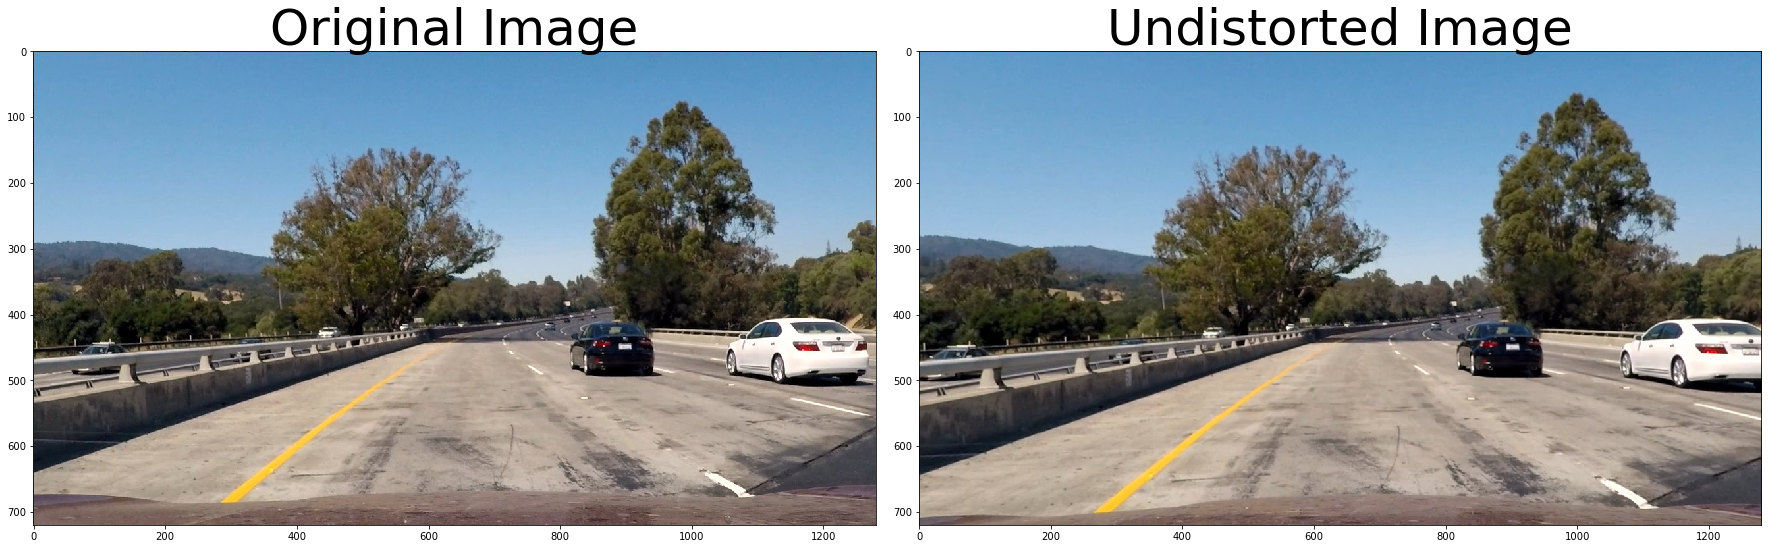

In [20]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img=loadimage('test_images/test1.jpg','rgb')
undist=undistort(img)

plot2imgs(img,undist,'Original Image','Undistorted Image')
plt.savefig('distorsionex')

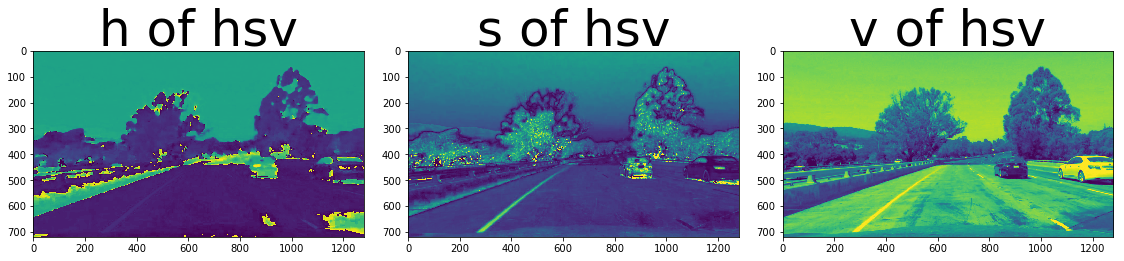

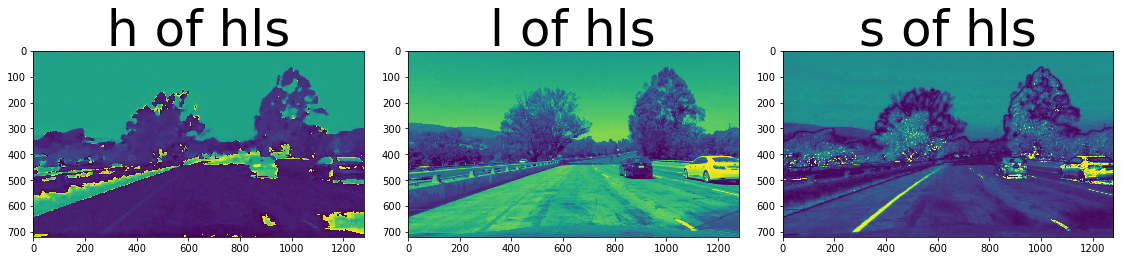

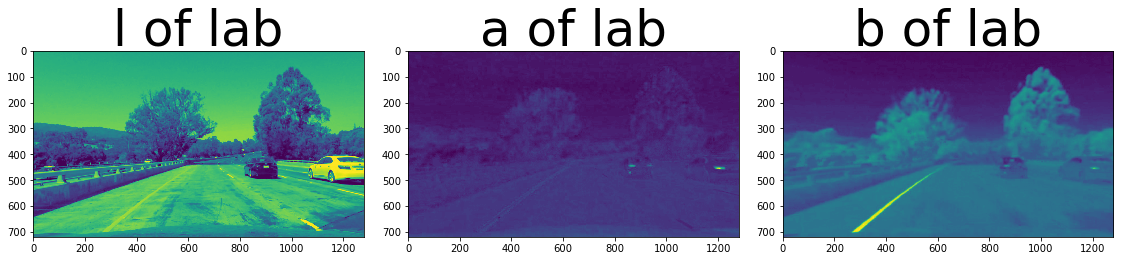

In [22]:
hsv_img= cv2.cvtColor(undist, cv2.COLOR_RGB2HSV)
h_hsv=hsv_img[:,:,0]
s_hsv=hsv_img[:,:,1]
v_hsv=hsv_img[:,:,2]
plot3imgs(h_hsv,s_hsv,v_hsv,'h of hsv','s of hsv','v of hsv')
hls_img= cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
h_hls=hls_img[:,:,0]
l_hls=hls_img[:,:,1]
s_hls=hls_img[:,:,2]
plot3imgs(h_hls,l_hls,s_hls,'h of hls','l of hls','s of hls')
plt.savefig('hls')
lab_img = cv2.cvtColor(undist, cv2.COLOR_RGB2Lab)
l_lab=lab_img[:,:,0]
a_lab=lab_img[:,:,1]
b_lab=lab_img[:,:,2]
plot3imgs(l_lab,a_lab,b_lab,'l of lab','a of lab','b of lab')
plt.savefig('lab')

In [6]:
def lab_treshold(img,channel, thresh):
    lab=cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
    
    binary= np.zeros_like(lab[:,:,channel])
    binary[(lab[:,:,channel] > thresh[0]) & (lab[:,:,channel] <= thresh[1])] = 1
   
    return binary

def hsv_treshold(img,channel, thresh):
    hsv=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    binary= np.zeros_like(hsv[:,:,channel])
    binary[(hsv[:,:,channel] > thresh[0]) & (hsv[:,:,channel] <= thresh[1])] = 1
   
    return binary

def hls_treshold(img,channel, thresh):
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    binary= np.zeros_like(hls[:,:,channel])
    binary[(hls[:,:,channel] > thresh[0]) & (hls[:,:,channel] <= thresh[1])] = 1
   
    return binary
def rgb_treshold(img,channel, thresh):
    rgb=img
    
    binary= np.zeros_like(rgb[:,:,channel])
    binary[(rgb[:,:,channel] > thresh[0]) & (rgb[:,:,channel] <= thresh[1])] = 1
   
    return binary

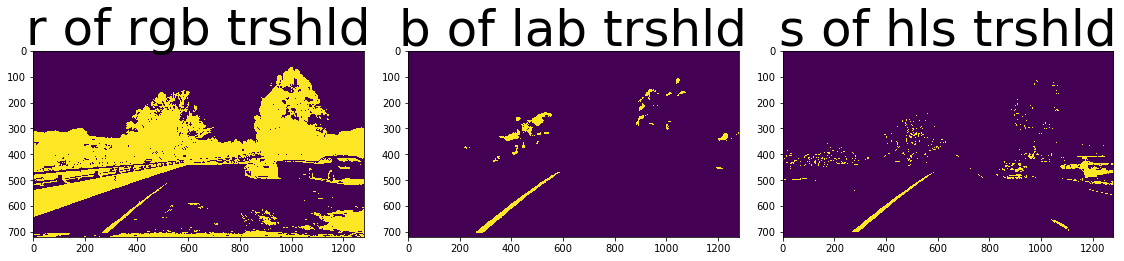

In [25]:
r=rgb_treshold(undist,2,(0,100))
s=hls_treshold(undist,2,(150,255))
b=lab_treshold(undist,2,(150,255))

plot3imgs(r,b,s,'r of rgb trshld','b of lab trshld','s of hls trshld')
plt.savefig('colormask')

In [8]:
def sobel_abs_treshold(img,orient='x',thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary= np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary

def sobel_mag_threshold(img, kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary = np.zeros_like(gradmag)
    binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary
def sobel_dir_threshold(img, kernel=3, thresh=(0, np.pi/2)):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary =  np.zeros_like(absgraddir)
    binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary
    

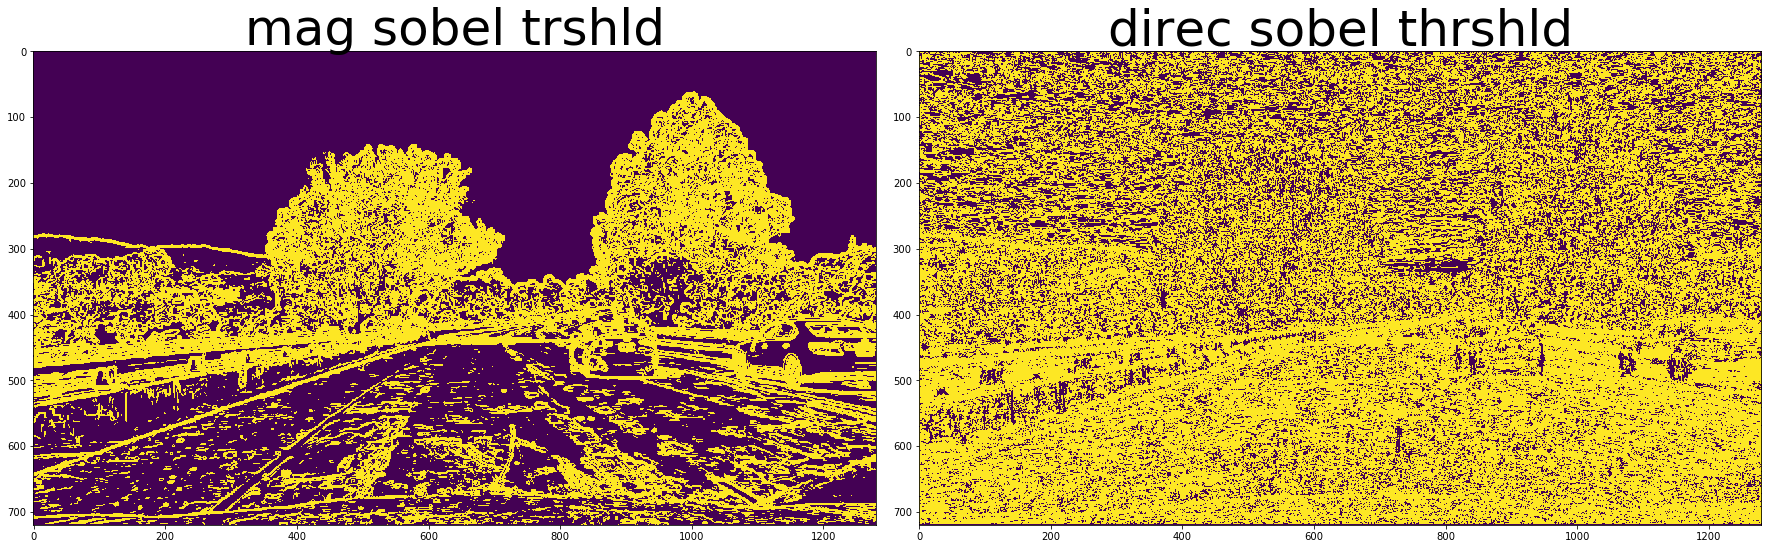

In [26]:

mag=sobel_mag_threshold(undist,5,(10,200))
direc=sobel_dir_threshold(undist,3,(np.pi/6,np.pi/2))

plot2imgs(mag,direc,'mag sobel trshld','direc sobel thrshld')
plt.savefig('sobalmask')

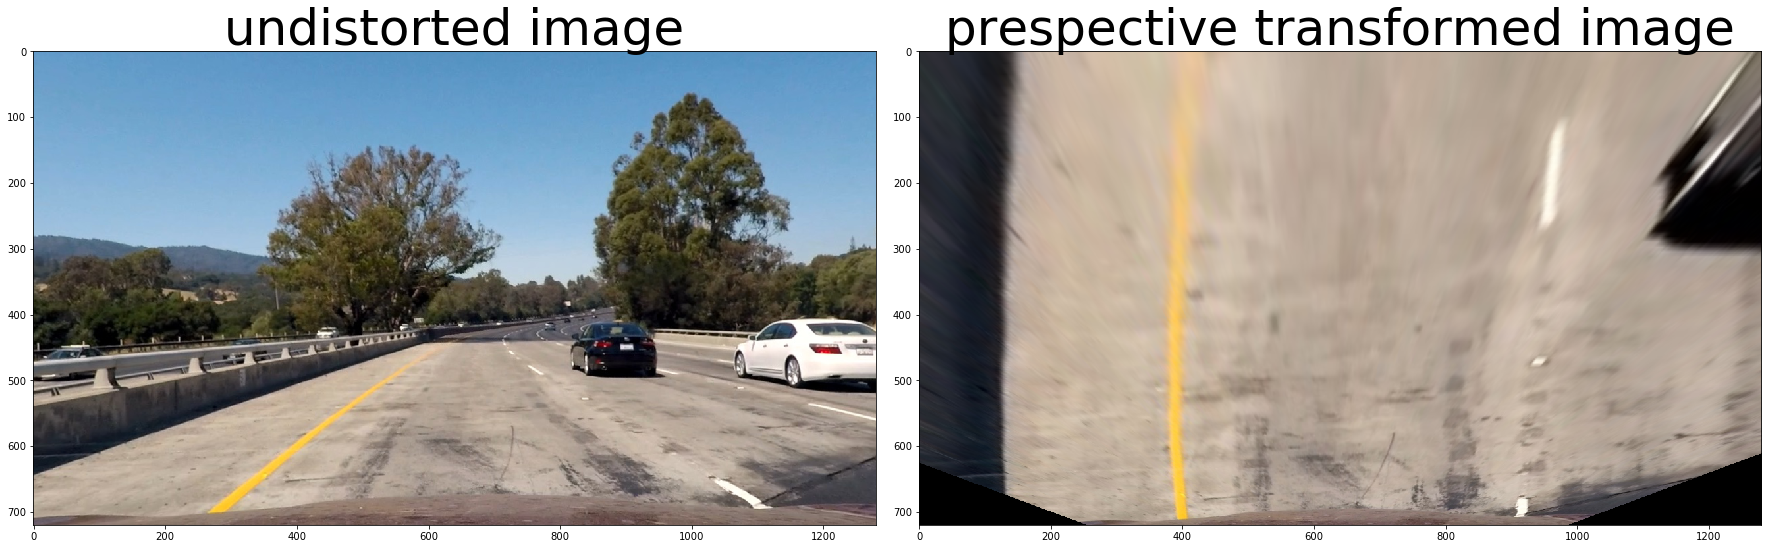

In [27]:

h,w=dst.shape[:2]

src = np.float32([(200,720),
                  (570,470), 
                  (720,470), 
                  (1150,720)])

"""
src = np.float32([(597,450),
                  (685,450), 
                  (260,683), 
                  (1043,683)])
"""

offset=370
dst = np.float32([(offset,h),
                  (offset,0),
                  (w-offset,0),
                  (w-offset,h)])

"""
dst = np.float32([(offset,0),
                  (w-offset,0),
                  (offset,h),
                  (w-offset,h)])

"""
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view


def warp(img,M):
    h,w=img.shape[:2]
    
    offset=370
    dst = np.float32([(offset,h),
                  (offset,0),
                  (w-offset,0),
                  (w-offset,h)])
    src = np.float32([(200,720),
                  (570,470), 
                  (720,470), 
                  (1150,720)])
    
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped
warped=warp(undist,M)

plot2imgs(undist,warped,'undistorted image','prespective transformed image')
plt.savefig('perspective')

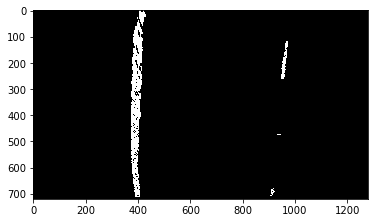

In [28]:
magdir_combined = np.zeros_like(mag)
magdir_combined[((mag== 1) | (direc == 1))] = 1

color_combined=np.zeros_like(mag)
color_combined[( (s == 1) | (b==1))] = 1

final_combined=np.zeros_like(mag)
final_combined[((magdir_combined== 1) & (color_combined == 1))] = 1


im=warp(final_combined,M)

mask = np.zeros_like(im)
h,w=im.shape[:2]

roi = np.array([[200,h-1], [200, 0],[1100,0], [1100, h-1]], dtype=np.int32)
cv2.fillPoly(mask, [roi], 1)
thresholded = cv2.bitwise_and(im, mask)

plt.imshow(thresholded,cmap='gray')
plt.savefig('tresholded')

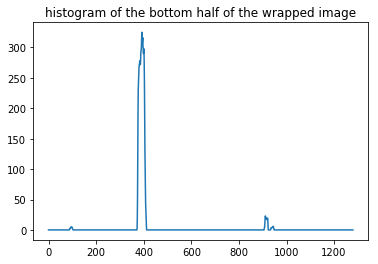

In [29]:
histogram = np.sum(im[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.title('histogram of the bottom half of the wrapped image')
plt.savefig('histogram')

In [34]:
def fitpoly(im) :  
    out_img = np.dstack((im, im, im))*255
    histogram = np.sum(im[im.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]/2)

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 10
    window_height = np.int(im.shape[0]/nwindows)

    nonzero = im.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = im.shape[0] - (window+1)*window_height
        win_y_high = im.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx)==0 or len(lefty)==0 or len(rightx)==0 or len(righty)==0:
        return [],[]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ploty = np.linspace(0, im.shape[0]-1, im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    """
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    """
    return left_fit,right_fit
"""
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
"""

"\nout_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]\nout_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]\nplt.imshow(out_img)\nplt.plot(left_fitx, ploty, color='yellow')\nplt.plot(right_fitx, ploty, color='yellow')\nplt.xlim(0, 1280)\nplt.ylim(720, 0)\n"

In [14]:
def find_rad_of_cur(left_fit,right_fit):
    yval = np.linspace(0, im.shape[0]-1, im.shape[0] )

    y_interest=np.max(yval)
    y_px2m=3/72
    x_px2m=3.7/700
    leftx = left_fit[0]*yval**2 + left_fit[1]*yval + left_fit[2]
    rightx = right_fit[0]*yval**2 + right_fit[1]*yval + right_fit[2]
    left_fit_cr = np.polyfit(yval*y_px2m, leftx*x_px2m, 2)
    right_fit_cr = np.polyfit(yval*y_px2m, rightx*x_px2m, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_interest*y_px2m + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_interest*y_px2m + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius=(left_curverad+right_curverad)/2

    center=1280/2
    left  = leftx[-1]
    right = rightx[-1]
    current = (left + right)/2
    actual_drift=x_px2m*(current-center)
    return radius, actual_drift

In [15]:
def fitpoly_nextframe(im,left_fit,right_fit):
    nonzero = im.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit,right_fit

def draw_lane(org_img,bin_img,left_fit,right_fit,Minv,rad_of_curve,drift):
    new_img = np.copy(org_img)
    warp_2d = np.zeros_like(bin_img).astype(np.uint8)
    warp_3d = np.dstack((warp_2d, warp_2d, warp_2d))
    h,w = bin_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_3d, np.int_([pts]), (0,255, 0))
    cv2.polylines(warp_3d, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(warp_3d, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)


    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_3d, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    if drift<0:
        text='Position: {:.2f} m left'.format(drift)
    else:
        text='Position: {:.2f} m right'.format(drift)
    
    cv2.putText(result,text,(20,130),cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    text = "Rad of Curv: {} m".format(int(rad_of_curve))
    
    cv2.putText(result,text,(20,80),cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
  
    
    return result


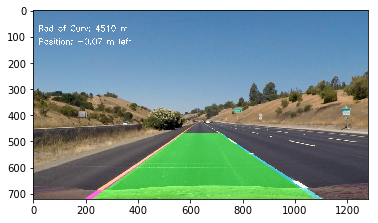

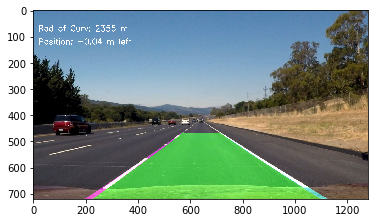

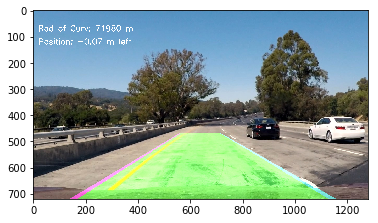

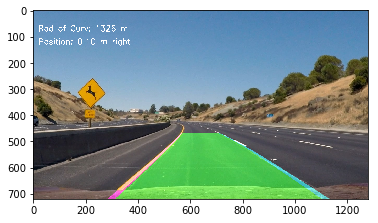

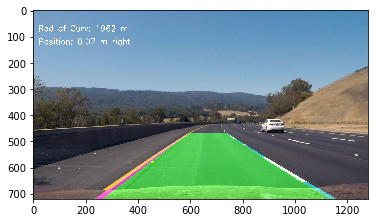

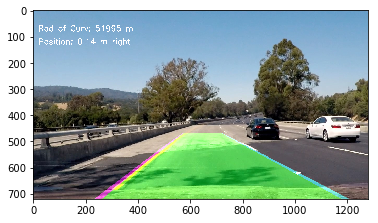

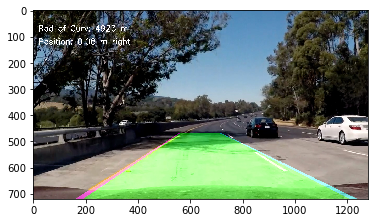

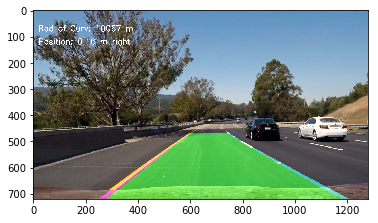

In [44]:
def pipeline(img):
    global counter
    counter+=1
    undist=undistort(img)
    
    
    r=rgb_treshold(undist,0,(150,255))
    s=hls_treshold(undist,2,(100,255))
    b=lab_treshold(undist,2,(150,255))
   
    mag=sobel_mag_threshold(undist,3,(10,200))
    direc=sobel_dir_threshold(undist,3,(np.pi/6,np.pi/2))

    magdir_combined = np.zeros_like(mag)
    magdir_combined[((mag== 1) & (direc == 1))] = 1

    color_combined=np.zeros_like(mag)
    color_combined[((s == 1) | (b==1) |(r==1))] = 1

    final_combined=np.zeros_like(mag)
    final_combined[((magdir_combined== 1) | (color_combined == 1))] = 1
    im=warp(final_combined,M)
    
    
    mask = np.zeros_like(im)
    h,w=im.shape[:2]

    roi = np.array([[200,h-1], [200, 0],[1100,0], [1100, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [roi], 1)
    thresholded = cv2.bitwise_and(im, mask)

    left_fit,right_fit=fitpoly(thresholded)
    
    rad_of_curve,drift=find_rad_of_cur(left_fit,right_fit)

    f_image=draw_lane(img,im,left_fit,right_fit,Minv,rad_of_curve,drift)
    plt.imshow(f_image)
    plt.savefig('smple'+str(counter))

    plt.figure()
    cv2.imwrite('sample'+str(counter)+'.jpg',f_image)
    return f_image,left_fit,right_fit

test_imgs=glob.glob('test_images/*.jpg')
#test_img=loadimage('test_images/test1.jpg','rgb')
#_,left_fit,right_fit=pipeline(test_img)
#plt.imshow(_)
#plt.show()
counter=0
for i in test_imgs:
    testimage=loadimage(i,'rgb')
    pipeline(testimage)



In [17]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def addprev(self,fit):
        self.recent_xfitted.append(fit)
        if len(self.recent_xfitted)>13:
            self.recent_xfitted=self.recent_xfitted[-13:]
    def avg(self,newfit):
        #print(len(self.recent_xfitted))
        
        if len(self.recent_xfitted)<5:
            self.recent_xfitted.append(newfit)
            return newfit
        else:
            
            meanval= np.mean(self.recent_xfitted,axis=0)
            newfit=newfit*0.5+meanval*0.5
            self.diffs=newfit-meanval
            
            #allow changes anly this much at a time
            tol2=0.000001
            tol1=0.01
            tol0=12
            if self.diffs[0]>tol2:
                newfit[0]=meanval[0]+tol2
            elif self.diffs[0]<-tol2:
                newfit[0]=meanval[0]-tol2
            
            if self.diffs[1]>tol1:
                newfit[1]=meanval[1]+tol1
            elif self.diffs[1]<-tol1:
                newfit[1]=meanval[1]-tol1
            
            
            if self.diffs[2]>tol0:
                newfit[2]=meanval[2]+tol0
            elif self.diffs[2]<-tol0:
                newfit[2]=meanval[2]-tol0
                   
            self.addprev(newfit)
            return newfit


In [41]:
def process_video(img):
    
    undist=undistort(img)
    
    
    #l=lab_treshold(undist,0,(150,255))
    s=hls_treshold(undist,2,(150,255))
    b=lab_treshold(undist,2,(150,255))
   
    mag=sobel_mag_threshold(undist,3,(90,255))
    direc=sobel_dir_threshold(undist,3,(0.0,1.5))

    magdir_combined = np.zeros_like(mag)
    magdir_combined[((mag== 1) | (direc == 1))] = 1

    color_combined=np.zeros_like(mag)
    color_combined[((s == 1) | (b==1))] = 1

    final_combined=np.zeros_like(mag)
    final_combined[((magdir_combined== 1) & (color_combined == 1))] = 1
    im=warp(final_combined,M)
    
    mask = np.zeros_like(im)
    h,w=im.shape[:2]

    roi = np.array([[200,h-1], [200, 0],[1100,0], [1100, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [roi], 1)
    im = cv2.bitwise_and(im, mask)

    
    if (l_line.detected==True) and (r_line.detected==True):
        l_line.current_fit,r_line.current_fit=fitpoly(im)#,l_line.current_fit,r_line.current_fit)
        
        if (l_line.current_fit==[]) or (r_line.current_fit==[]):
            l_line.current_fit,r_line.current_fit=fitpoly(im)
    else:
        l_line.current_fit,r_line.current_fit=fitpoly(im)
    
    if l_line.current_fit==[]:
        l_line.detected=False
        l_line.current_fit=l_line.recent_xfitted[-1]
    else:
        l_line.detected=True
    if r_line.current_fit==[]:
        r_line.detected=False
        r_line.current_fit=r_line.recent_xfitted[-1]
    else:
        r_line.detected=True
    l_final_curve=l_line.avg(l_line.current_fit)
    r_final_curve=r_line.avg(r_line.current_fit)
    
    rad_of_curve,drift=find_rad_of_cur(l_final_curve,r_final_curve)
    f_image=draw_lane(img,im,l_final_curve,r_final_curve,Minv,rad_of_curve,drift)
        
        
    
    return f_image
    
   
    
l_line=Line()
r_line=Line()
  

vid_out='output_video.mp4'
vid_inp=VideoFileClip("project_video.mp4")

out=vid_inp.fl_image(process_video)
%time out.write_videofile(vid_out,audio=False)


[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:36<00:00,  4.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

Wall time: 4min 37s
